In [312]:
# A tutorial & demo of applying Bayes' theorem to physical model parameter extraction
# Author: Jake Coleman & Weiyao Ke

import subprocess
# git clone https://github.com/keweiyao/BayesExample
# Python3 
# python package: sklearn, numpy, matplotlib scipy, emcee (for MCMC)
# R
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from scipy import stats
import emcee
import numpy as np


%matplotlib inline

In [318]:
from scipy.integrate import quad
from scipy.special import gammaln, gamma
from scipy.interpolate import interp1d
# Model based on the energy loss formula in https://arxiv.org/pdf/1808.05310.pdf



# initial jet spectra in p+p
# Load experimental p+p-->jet+X data x=pT, y=dsigma/dpT
X, Y = np.loadtxt("./pythia_pp2jets_5020.dat").T # 32.5 < pT < 1100 TeV
interped_data = interp1d(np.log(X), np.log(Y), kind='linear', fill_value='extrapolate')

@np.vectorize
def dNpp_dpT(pT):
    return np.exp( interped_data(np.log(pT)) )

# jet spectra after jet energy loss in A+A
# dN/dpT = integrate dN0/dpT' W(pT, pT+Delta pT; a,b,c) d(Delta pT)

# integrate dN0/dpT' W(pT, pT+x) * x * dx /x
# integrate dN0/dpT' W(pT, pT+x) * x * d ln(x)
@np.vectorize
def dNAA_dpT(pT, a, b, c):
    def WAA(delta_pT):
        avg_delta_pT = b*pT**c * np.log(pT)
        x = delta_pT / avg_delta_pT
        return a**a/gamma(a) * x**(a-1) * np.exp(-a*x) / avg_delta_pT
    def dNdpT_ddeltapT(ln_delta_pT):
        delta_pT = np.exp(ln_delta_pT )
        return WAA(delta_pT) * dNpp_dpT(pT+delta_pT) * delta_pT
    result, error = quad(dNdpT_ddeltapT, # function to be integrate
                    np.log(.01), np.log(pT), # lower and upper bound of integration,
                    epsrel=1e-3
                  )
    return result

@np.vectorize
def ElossModel_RAA(pT, a, b, c):
    return dNAA_dpT(pT, a, b, c)/dNpp_dpT(pT)

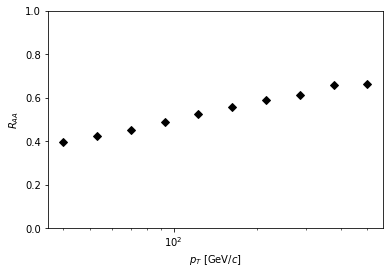

In [321]:
# Test this toy model:
a = 2
b = 1.4
c = 0.2
pT = np.exp(np.linspace(np.log(40),np.log(500),10))
#pT = np.linspace(40, 1000, 30)
RAA = [ElossModel_RAA(ipT, a, b, c) for ipT in pT]
plt.plot(pT, RAA, 'kD')
plt.semilogx()
plt.ylim(0,1)
plt.xlabel(r"$p_T$ [GeV/$c$]")
plt.ylabel(r"$R_{AA}$")
plt.savefig("RAA_test.png", dpi=300)

## Step 1: validation

##### 1.1 Create PseudoData

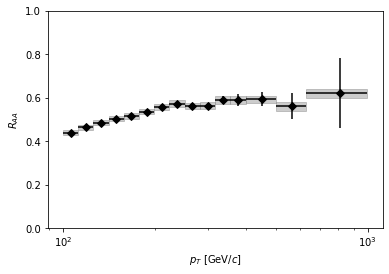

In [322]:
# Assume the true values of Nature is 
atruth = 1
btruth = 1.4
ctruth = 0.3

def PseudoMeasurement(StatLevel=0.05, SysLevel=0.05):
    np.random.seed(10)
    pTbin = np.exp( np.linspace(np.log(50), np.log(1000), 10) )
    pT = (pTbin[1:] + pTbin[:-1])/2. # middle point of each pT bin
    be = (pTbin[1:] - pTbin[:-1])/2. # the half-bin width
    # truth: Raa without any uncertainty
    y_truth = np.array([ElossModel_RAA(ipT, atruth, btruth, ctruth) for ipT in pT])
    
    # generate pseudo uncertainty
    stat = np.random.normal(0, StatLevel, pT.shape[0]) # on average 5% stat uncertainty, uncorrelated
    sys = np.random.normal(0, SysLevel) # on avearage, 5% sys uncertainty, fully correlated among all pT points
    results = y_truth * (1. + stat) * (1. + sys)
    return pT, be, results, StatLevel*results, SysLevel*y_truth

def RealMeasurement(centrality='0-10'):
    # load exp RAA off sqrts = 5.02 TeV, centrality = 0-10
    pT, pTl, pTh, Raa, sys1, sys2, stat = np.loadtxt("ExpData/atlas-raa-{}-R0d4.dat".format(centrality),
                                                     usecols=[0,1,2,3,4,5,6]).T
    return pT, (pTh-pTl)/2., Raa, stat, (sys1-sys2)/2.

pT, pTbin, Raa, RaaStat, RaaSys = RealMeasurement()
plt.errorbar(pT, Raa, xerr=pTbin, yerr=RaaStat,fmt='kD')
for ix, iy, ixb, isys in zip(pT, Raa, pTbin, RaaSys):
    plt.fill_between([ix-ixb,ix+ixb],[iy-isys,iy-isys], [iy+isys, iy+isys], color='gray', alpha=.4)
plt.semilogx()
plt.ylim(0,1)
plt.xlabel(r"$p_T$ [GeV/$c$]")
plt.ylabel(r"$R_{AA}$")
plt.savefig("RAA_test.png", dpi=300)

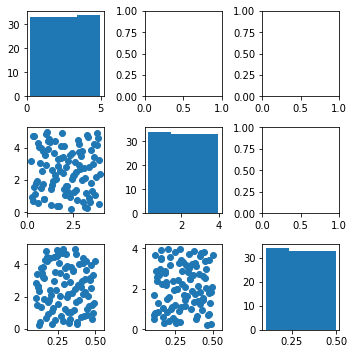

In [341]:
from pyDOE import lhs
# Use pyDOE to generate a Larin-Hypercube design in the 3D parameter space (a,b,c)
ranges = np.array([[.2, 5], # range of A
                   [0.2, 4], # range of B
                   [0.1, .5], # range of C
                  ])
Dim = 3
Nsamples = 100
# call pyDOE 
design = lhs(Dim, Nsamples, 'maximin')
# rescale unit design to the desired range
for i in range(Dim):
    design[:,i] = design[:,i]*(ranges[i,1]-ranges[i,0]) + ranges[i,0]
fig, axes = plt.subplots(3,3, figsize=(5,5))
for i in range(Dim):
    for j in range(0,i+1):
        if (i==j):
            axes[i,j].hist(design[:,i],bins=3)
        else:
            axes[i,j].scatter(design[:,i], design[:,j])
plt.tight_layout(True)

In [342]:
# To do: generate the model calcualtions on each of the design points, and plot them along with the Pseudo data

model_y = []
for i, ip in enumerate(design):
    if i%10==0:
        print(i)
    model_y.append(ElossModel_RAA(pT, *ip)) #[100 by NpT]
model_y = np.array(model_y)

0
10
20
30
40
50
60
70
80
90


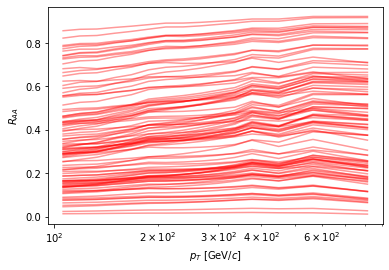

In [343]:
for iy in model_y:
    plt.plot(pT, iy, 'r-', alpha=.4)
plt.semilogx()
plt.xlabel(r"$p_T$ [GeV/$c$]")
plt.ylabel(r"$R_{AA}$")
plt.savefig("RAA_prior.png", dpi=300)

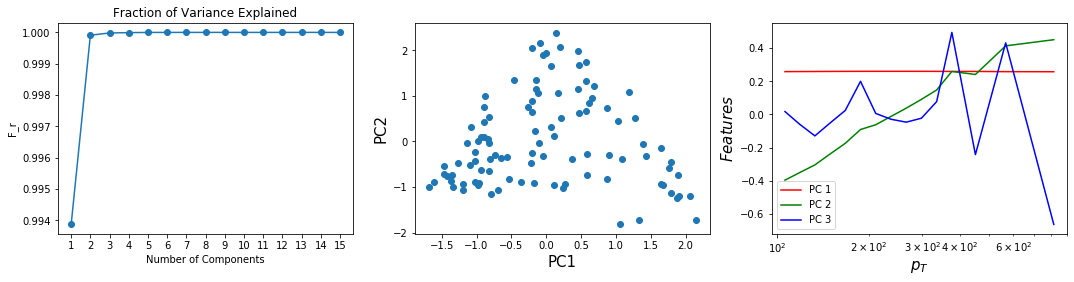

In [344]:
# Decompose the Raa data into several principal components
npc = 2 # choose how much PCs to construct the calculation
# Standard Sclar: remove the mean of the calculation, and rescled by 1/standard-deviation
scaler = StandardScaler(copy=True)
pca = PCA(copy=True, whiten=True, svd_solver='full')

# Keep only the first `npc` principal components
Z = pca.fit_transform(scaler.fit_transform(model_y)) # transform [Ndeisgn x NpT] --> [Ndesign x Npc] (Npc=NpT)

# Truncate to keep only the first npc Principal components
Z = Z[:,:npc]

# The transformation matrix from PC to Physical space
Trans_Matrix = (  pca.components_
                * np.sqrt(pca.explained_variance_[:, np.newaxis])
                * scaler.scale_ )

# ...
plt.figure(figsize=(15,4))
F_r = np.cumsum(pca.explained_variance_ratio_)
plt.subplot(1,3,1)
plt.plot(range(len(F_r)),F_r,'-o')
ticks = np.arange(0, len(F_r), 1)
labels = ticks + 1
plt.xticks(ticks, labels)
plt.title('Fraction of Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('F_r')

plt.subplot(1,3,2)
plt.scatter(Z[:, 0], Z[:, 1])
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)

plt.subplot(1,3,3)
for i, (comp, color) in \
        enumerate(zip(pca.components_, 'rgb')):
    plt.plot(pT, comp, color=color, label='PC {}'.format(i+1))
plt.xlabel('$p_T$', fontsize=15)
plt.ylabel('$Features$', fontsize=15)
plt.semilogx()
plt.legend()
plt.tight_layout(True)

In [345]:
######## Step 4-1: Building Emulators for each of the npc principal components
# Kenel = sigma^2 exp(-1/2 |x_i-x_j|^2 / L^2) + white noise #*(diag matrix)
kernel = (
    1. * kernels.RBF(
        length_scale=[1., 1., 1.],
        length_scale_bounds=[(.1,10), (.1, 10), (.1, 10)]
    )  
    + kernels.WhiteKernel(.1, noise_level_bounds=(1e-5,1e3))
)

# Build and train each GP
gps = [ GPR(kernel=kernel, n_restarts_optimizer=10) 
        for i in range(npc) ] # only build GP emulators for the first Npc principle components
# Print the optimized GP hyperparameters (variacne, correlation length, and white noise level) for sanity check
for i, gp in enumerate(gps):
    gp.fit(design, Z[:,i])
    print('RBF: ', gp.kernel_.get_params()['k1'])
    print('White: ', gp.kernel_.get_params()['k2'])

RBF:  2.34**2 * RBF(length_scale=[2.29, 1.34, 0.493])
White:  WhiteKernel(noise_level=5.54e-05)
RBF:  2.65**2 * RBF(length_scale=[2.72, 1.32, 0.259])
White:  WhiteKernel(noise_level=1.43e-05)


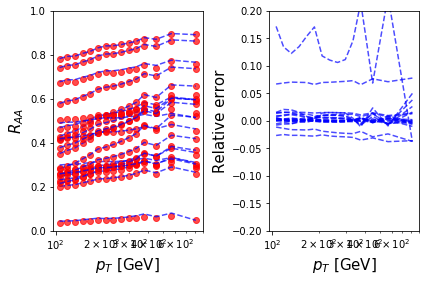

In [346]:
### Step 4-2: Validating the emulators #######################
# Use new sets of parameters --> true model calcualtions
#                       |------> go through GP --> inverse transformation of PCA --> interpolated calualtions
#ranges = np.array([[0.25,4], # range of A
#                   [0.2, 5], # range of B
#                   [0.01, .5], # range of C
#                  ])
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
np.random.seed(1)
for n in range(20):
    a = ranges[0,0]+(ranges[0,1]-ranges[0,0]) * np.random.rand() 
    b = ranges[1,0]+(ranges[1,1]-ranges[1,0]) * np.random.rand() 
    c = ranges[2,0]+(ranges[2,1]-ranges[2,0]) * np.random.rand()
    # GP prediction
    z = np.array([gp.predict([(a, b, c)])[0] for gp in gps]) # --> z = [PC'_1(a,b,c), PC'_2(a,b,c), ...]
    pred = np.dot(z, Trans_Matrix[:z.shape[-1]]) + scaler.mean_ # y_i = sum_j z_j * (PC_invTRANFORM)_ji + mean_i
    # model calcuatlion
    calc = ElossModel_RAA(pT, a, b, c)
    
    ax1.plot(pT, calc, 'ro', alpha=0.7, label='True calculation at (a,b,c)')
    ax1.plot(pT, pred, 'b--', alpha=0.7, label='GP+PCA prediction at (a,b,c)')
    ax2.plot(pT, (pred-calc)/calc, 'b--', alpha=0.7)
ax1.set_ylim(0,1)
ax1.semilogx()
ax1.set_xlabel(r'$p_T$ [GeV]', fontsize=15)
ax1.set_ylabel(r'$R_{AA}$', fontsize=15)
ax2.set_ylim(-.2, .2)
ax2.set_xlabel(r'$p_T$ [GeV]', fontsize=15)
ax2.set_ylabel('Relative error', fontsize=15)

plt.tight_layout(True)

In [347]:
##### Helper functions for this block ###################
from scipy.linalg import lapack

# Prior:
def prior_ln_pdf(theta):
    if (theta<ranges[:,0]).any() or (theta>ranges[:,1]).any():
        return -np.inf
    else:
        return 0.

# calculate the log of Gaussian density with 
# residual dy = y - yexp and covariance matrix cov.
# - 1/2 * dy^T * cov^[-1] * dy - 1/2*ln(|cov|)
def lnLL(dy, cov): 
    L, info = lapack.dpotrf(cov, clean=False)
    alpha, info = lapack.dpotrs(L, dy)
    return -.5*np.dot(dy, alpha)-np.log(L.diagonal()).sum()

# Raa, RaaStat, RaaSys
# Error matrix:
# 1. Experimetnal uncertaity = stat + systemic (uncorr) + systemic (corr)
Assume_SysError_Corr = True
Exp_Cov = np.diag(RaaStat**2) + np.outer(RaaSys, RaaSys) \
          if Assume_SysError_Corr else \
          np.diag(RaaStat**2) + np.diag(RaaSys**2)
# 2. Truncation uncertatity: we need use all principal components to "100%" describe the calculation
#    but we only included 5 of them. We treat the variacne of those "left overs" as another uncertainty in the prediction
Truncation_Cov = np.dot(Trans_Matrix[npc:].T, Trans_Matrix[npc:])
# 3. Interpolation uncertainty: GP itself will be able to evaluate the interpolation uncertainty
# we interpolate PC: ypc +/- pc_error
def Interpolation_Cov(pc_error):
    return np.matmul(Trans_Matrix[:npc].T * pc_error**2, # pc_error is a vector
                    Trans_Matrix[:npc])

def likelihood_ln_pdf(theta):
    pc_mean, pc_error = np.array([gp.predict([theta], return_std=True) for gp in gps]).T[0]
    pred = np.dot(pc_mean, Trans_Matrix[:z.shape[-1]]) + scaler.mean_
    dy = pred - Raa
    cov = Exp_Cov + Truncation_Cov + Interpolation_Cov(pc_error)
    return lnLL(dy, cov)

# Finally ln(Posterior) = ln(prior) + ln(likelihood)
def posterior_ln_pdf(theta):
    ln_pr = prior_ln_pdf(theta)
    ln_like = likelihood_ln_pdf(theta) 
    return ln_pr + ln_like


In [348]:
######### Step 6: Run MCMC ###########################
# Fill 1) the number of samples 2) burnin steps
# 3) dimsional of the problem 4) number of mcmc walkers
# Hint: this may take a while, so start with smaller numbers
nsteps = 3000
nburnin = 1000
ndim = 3
nwalkers = 10 * ndim
print(emcee.__version__)
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior_ln_pdf)
p0 = np.random.rand(nwalkers, ndim)
p0 = (1.-p0)*ranges[:, 0] +  p0*ranges[:, 1]
out_post = sampler.run_mcmc(p0, nsteps)
samples = sampler.chain[:, nburnin:, :].reshape((-1, ndim))

2.2.1


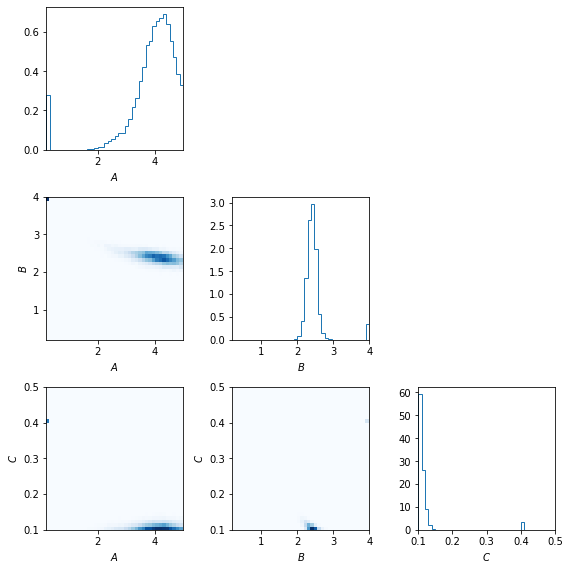

In [349]:
##### Step 7: Analyze the posterior distribution ########
# 1) Run this block and plot the posterior distribution
# 2) Does the posterior fairly estimates the true values (red)?
# 3) How does the posterior change it we take into account the
#    correlation among the sys-error?
figure, axes = plt.subplots(figsize=(8,8), ncols=ndim, nrows=ndim)
names = [r"$A$", r"$B$",r"$C$"]
truth = [atruth, btruth, ctruth]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(samples[:,i], bins=40,
                    range=ranges[i], histtype='step', 
                    density=True)
            ax.set_xlabel(names[i])
            #ax.axvline(x=truth[i], color='r', linewidth=1)
            ax.set_xlim(*ranges[j])
        if i>j:
            ax.hist2d(samples[:, j], samples[:, i], 
                      bins=40, range=[ranges[j], ranges[i]], 
                      cmap='Blues')
            ax.set_xlabel(names[j])
            ax.set_ylabel(names[i])
            #ax.axvline(x=truth[j], color='r', linewidth=1)
            #ax.axhline(y=truth[i], color='r', linewidth=1)
            #ax.plot(truth[j], truth[i], 'ro')
            ax.set_xlim(*ranges[j])
            ax.set_ylim(*ranges[i])
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
plt.savefig("corr-results.pdf")

In [351]:
# Define single parameter (single-param marginalized) posterior and credible limits
for i in range(ndim):
    x = samples[:,i]
    x50 = np.quantile(x, 0.5)
    x05 = np.quantile(x, 0.05)
    x95 = np.quantile(x, 0.95)
    print("90% CL of the {}th param is {:1.3f} + {:1.3f} - {:1.3f}".format(i+1, x50, x95-x50, x50-x05) )

90% CL of the 1th param is 4.083 + 0.766 - 1.562
90% CL of the 2th param is 2.411 + 0.261 - 0.213
90% CL of the 3th param is 0.108 + 0.024 - 0.007


Text(0.5, 1.0, 'For jets in 0-10% centrality')

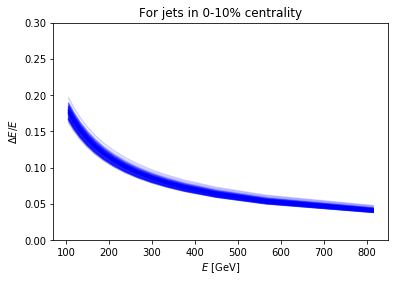

In [366]:
# Energy loss Delta pT = B * pT^C * ln(pT)
draw_indices = np.random.choice(np.arange(len(samples)),100)
draws = samples[draw_indices]
for p in draws:
    a,b,c = p
    plt.plot(pT, b*pT**c*np.log(pT) / pT, 'b-', alpha=.2)
plt.ylim(0,.3)
plt.ylabel(r"$\Delta E/E$")
plt.xlabel(r"$E$ [GeV]")
plt.title("For jets in 0-10% centrality")

In [367]:
# To do:
# 1) wait for me to update the pp spectra
# 2) Repeat this for 30-40%, 60-70%
# 3) Repeat for 2.76 TeV jets
# 4) Repeat for 0.2 TeV jets
# 5) Summarize how energy loss evolves with centrality  and beam energy (varying the T)

## Step 2: use experimental data of inclusive jet Raa